In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis Libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms, models

#miscelaneous
from google.colab import files

The code cell below can be run to in order to download the 6000 images dataset that was used for training the ResNet-34 model

In [1]:
#downloading the colorectal cancer dataset that will be used for training
if not os.path.exists("Dataset_1.zip"):
  !gdown 1nkn9BZ95ODrscLkacvx9-O6ydCrtLOXa
  !unzip Dataset_1.zip
else:
  print("The dataset has already been downloaded. Skipping this step.")

NameError: name 'os' is not defined

Run the code cell below in order to download the sample dataset for colorectal cancer (only 100 images)

In [4]:
if not os.path.exists("colorectal_cancer_sample.zip"):
  !gdown 1ilx-j7TUuswnzzfFLsCq6A8iig68kGEW
  !unzip colorectal_cancer_sample.zip
else:
  print("The dataset has already been downloaded. Skipping this step.")

The dataset has already been downloaded. Skipping this step.


This part contains the function that will load the images and prepare the training, validation, and testing sets.

In [5]:
#preparing and loading the images in the dataset
def loadImages(path, batch_size):
  #firstly defining the transformations used on the images
  transformation = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomRotation(20),
      transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
      transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
      transforms.RandomInvert(), #added in attempt 4
      transforms.RandomPerspective(), #added in attempt 4
      transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  #now loading the images
  dataset = datasets.ImageFolder(path, transform=transformation)

  #defining the sizes of the training, validation, and testing sets. we will be
  #using a 60:20:20 ratio leads to overfitting, try 70:15:15 or 80:10:10
  dataset_size = len(dataset)
  train_size = int(0.7*dataset_size)
  validation_size = int(0.15*dataset_size)
  test_size = dataset_size - (train_size + validation_size)

  #now splitting the dataset into the subsets
  train_set, validation_set, test_set = random_split(dataset, [train_size, validation_size, test_size])

  #creating dataloaders
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader, validation_loader, test_loader

Functions to save and load the model

In [6]:
def save_model(model, optimizer, epoch, path='model_checkpoint.tar'):
  checkpoint = {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}
  torch.save(checkpoint, path)

def load_model(model, optimizer, path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']

  return epoch

Function to train model <br>

In [7]:
def train_model(model, loss_func, optimizer, train_loader, validation_loader, device, num_epochs):
  train_losses = []
  validation_losses = []

  for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    #Save the state of the model every 20 epochs
    if ((epoch % 20) == 0):
      save_model(model, optimizer, epoch)

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()

      outputs = model(images)
      train_loss = loss_func(outputs, labels)
      train_loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 1.2)
      optimizer.step()

      epoch_loss += train_loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    #validation step
    model.eval()
    val_loss = 0
    with torch .no_grad():
      for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        val_loss += loss_func(outputs, labels).item()

    val_loss /= len(validation_loader)
    validation_losses.append(val_loss)

    #saving model if this was the last epoch
    if (epoch == (num_epochs - 1)):
      save_model(model, optimizer, epoch)

  return train_losses, validation_losses

Function for testing

In [8]:
def test_model(model, test_loader, device):
  model.eval()
  y_pred = []
  y_true = []

  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      dummy_var, pred_labels = torch.max(outputs, 1)
      y_pred.extend(pred_labels.cpu().numpy())
      y_true.extend(labels.cpu().numpy())

  return y_pred, y_true

This code cell is in charge of initializing model and dataloaders.<br>
It is set to run with the initial 6000 images dataset by default. To run it with the sample dataset, uncomment the last line in the cell and comment out the one above.<br> 

In [ ]:
  model = models.resnet34()
  model.fc = nn.Linear(model.fc.in_features, 3)

  #checking if cuda is available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)

  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) #added weight decay to see if it reduces overfitting

  train_loader, validation_loader, test_loader = loadImages("Colorectal Cancer", 128) #comment this out to run training with the sample dataset
  #train_loader, validation_loader, test_loader = loadImages("colorectal_cancer_sample", 128) #uncomment to run with sample dataset

<h2>Training and Testing</h2>
<b>1st Attempt:</b> trained model using batch size of 64 and learning rate of 0.01. The model is overfitting. <br>
<b>2nd Attempt: </b>changed batch size to 128 and larning rate to 0.001. Loss is more stable during the first 40 epochs but the model is still overfitting<br>
<b>3rd attempt: </b>changed ratio of training, validation and testing sets to 70:15:15 respectively and added weight decay value of 0.001 to Adam optimizer. Improved performance with respect to previous attempts but the model still overfits <br>
<b>4th Attempt: </b> added 4 new transformations in order to artificially increase training set size: `RandomVerticalFlip`, `RandomInvert`, `GaussianBlur`, and `RandomPerspective`. Increased weight decay to 0.01. Performs worse than before.<br>
<b>5th Attempt: </b>lowered weight decay to 0.0001 and removed `GaussianBlur` and `RandomVerticalFlip`.<br>
<b>6th attempt: </b>Added back `GaussianBlur`and `RandomVerticalFlip`; weight decay back to 0.001. Performance is similar to 5th attempt<br>
<b>7th attempt: </b>Adjusted values of `RandomRoation` and `ColorJitter`. Added gradient clipping.<br>
<b>8th attempt: </b>batch size reduced to 64; learning rate lowered to 0.0001<br>
<b>9th attempt: </b>implementing dropout for testing purposes only, task 2 utilizes only the weights from attempt 8 and so does the report

Model Accuracy: 0.6666666666666666
Classification report:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       1.00      0.83      0.91         6
           2       0.50      1.00      0.67         4

    accuracy                           0.67        15
   macro avg       0.67      0.68      0.62        15
weighted avg       0.70      0.67      0.64        15

Confusion matrix:
 [[1 0 4]
 [1 5 0]
 [0 0 4]]


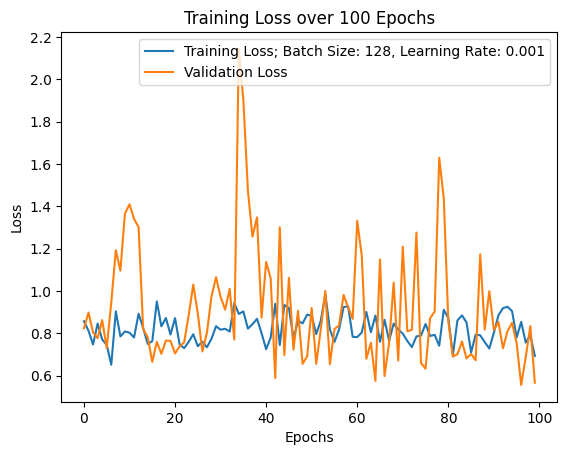

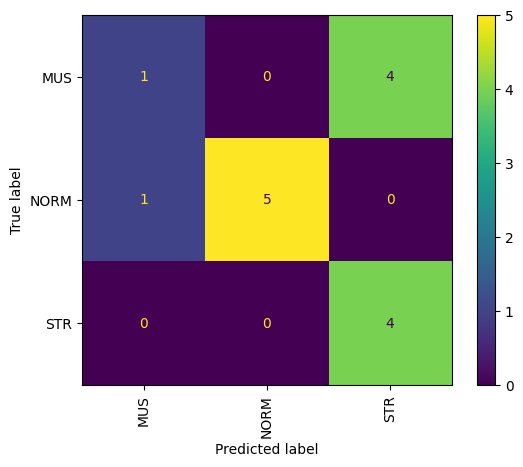

In [13]:
  model_train_loss, model_validation_loss = train_model(model, loss_function, optimizer, train_loader, validation_loader, device, 100)

  plt.plot(model_train_loss, label=f'Training Loss; Batch Size: {128}, Learning Rate: {0.001}')
  plt.plot(model_validation_loss, label='Validation Loss')
  plt.title(label="Training Loss over 100 Epochs")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  y_pred, y_true = test_model(model, test_loader, device)
  print(f'Model Accuracy: {accuracy_score(y_true, y_pred)}')
  print(f'Classification report:\n {classification_report(y_true, y_pred)}')
  print(f'Confusion matrix:\n {confusion_matrix(y_true, y_pred)}')

  classes=['MUS', 'NORM', 'STR']

ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=classes,
    cmap='viridis',
    xticks_rotation='vertical'
)

  #files.download('model_checkpoint.tar')

t-SNE

In [14]:
#download the trained weights
!gdown 12LQ-GVdlMLDK-xmZSkTrtfgVCnEV2AQt
path = 'attempt8.tar'

dummy_epoch = load_model(model, optimizer, path)

Downloading...
From (original): https://drive.google.com/uc?id=12LQ-GVdlMLDK-xmZSkTrtfgVCnEV2AQt
From (redirected): https://drive.google.com/uc?id=12LQ-GVdlMLDK-xmZSkTrtfgVCnEV2AQt&confirm=t&uuid=08235052-29ca-42ae-9ce2-0c1ee2869d3b
To: /content/attempt8.tar
100% 256M/256M [00:04<00:00, 56.3MB/s]


<ipython-input-6-41651b26aca9>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


In [15]:
def extract_features_for_tsne(model, data_loader, device):

    model.eval()  # Set model to evaluation mode
    features, labels = [], []
    # Remove the classification layer (last layer) to get only feature outputs
    model_features = nn.Sequential(*list(model.children())[:-1])

    with torch.no_grad():
        for images, target_labels in data_loader:
            images = images.to(device)

            # Remove the final layer for feature extraction (assuming model_features is the model without the last layer)
            outputs = model_features(images)  # Replace model with model_features if the last layer was sliced
            features.append(outputs.view(outputs.size(0), -1).cpu().numpy())  # Flatten feature tensor
            labels.extend(target_labels.cpu().numpy())  # Collect labels on CPU for t-SNE

    # Concatenate all features for t-SNE processing
    features = np.concatenate(features, axis=0)

    return features, labels

In [ ]:
def plot_tsne(features, labels, dataset_name, label_mapping):
  # Apply t-SNE
  tsne = TSNE(n_components=2, random_state=42, perplexity=max(5, min(30, features.shape[0] - 1)))
  reduced_features = tsne.fit_transform(features)

  unique_classes = np.unique(labels)
  num_classes = len(unique_classes)

  plt.figure(figsize=(10, 6))
  colors = plt.cm.get_cmap('viridis', num_classes)

  for class_index in unique_classes:
    indices = np.where(labels == class_index)
    class_name = label_mapping.get(class_index, f"Class {class_index}")
    plt.scatter(
      reduced_features[indices, 0],
      reduced_features[indices, 1],
      label= class_name,
      c=[colors(class_index)],
      alpha=0.7,
    )

  plt.title(f"t-SNE Visualization of CNN Extracted Features - {dataset_name}")
  plt.xlabel("t-SNE Feature 1")
  plt.ylabel("t-SNE Feature 2")
  plt.legend(loc='best')
  plt.show()

The code cell below is set to run with the original dataset by default. To run it with the sample dataset, uncomment the last line and comment out the line above.

Using perplexity: 14


<ipython-input-22-d8e2e06a5a2b>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_classes)


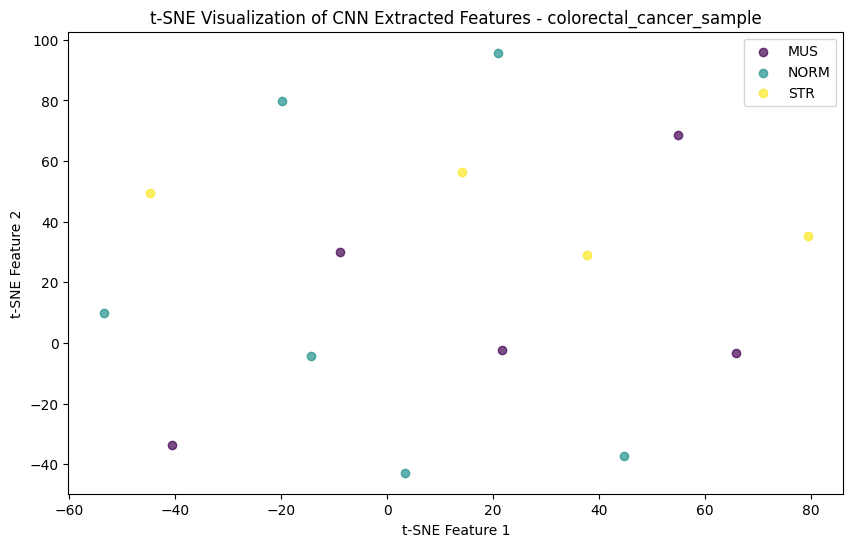

In [23]:
features, labels = extract_features_for_tsne(model, test_loader, device)
plot_tsne(features, labels, dataset_name = "Colorectal Cancer", label_mapping = {0: 'MUS', 1: 'NORM', 2: 'STR'})
#plot_tsne(features, labels, dataset_name = "colorectal_cancer_sample", label_mapping = {0: 'MUS', 1: 'NORM', 2: 'STR'})